In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
#import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro, normaltest, anderson, chi2_contingency, pearsonr, ttest_ind
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import statsmodels.api as sm
from statsmodels.formula.api import ols
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/students-performance-in-2024-jamb/jamb_exam_results.csv


In [2]:
#Отключаем предупреждения в итоговом отчёте
import warnings
warnings.filterwarnings('ignore')

In [3]:
df = pd.read_csv('/kaggle/input/students-performance-in-2024-jamb/jamb_exam_results.csv')
#Номер студента на успеваемость точно не влияет, так что выкидываем его
df=df.drop('Student_ID', axis=1)
activate_all=False
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,192,22,78,4,12.4,Public,Urban,Yes,Yes,High,Medium,17,Male,Low,Tertiary,2
1,207,14,88,4,2.7,Public,Rural,No,Yes,High,High,15,Male,High,NaN,1
2,182,29,87,2,9.6,Public,Rural,Yes,Yes,High,Medium,20,Female,High,Tertiary,2
3,210,29,99,2,2.6,Public,Urban,No,Yes,Medium,High,22,Female,Medium,Tertiary,1
4,199,12,98,3,8.8,Public,Urban,No,Yes,Medium,Medium,22,Female,Medium,Tertiary,1


Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   JAMB_Score                    5000 non-null   int64  
 1   Study_Hours_Per_Week          5000 non-null   int64  
 2   Attendance_Rate               5000 non-null   int64  
 3   Teacher_Quality               5000 non-null   int64  
 4   Distance_To_School            5000 non-null   float64
 5   School_Type                   5000 non-null   object 
 6   School_Location               5000 non-null   object 
 7   Extra_Tutorials               5000 non-null   object 
 8   Access_To_Learning_Materials  5000 non-null   object 
 9   Parent_Involvement            5000 non-null   object 
 10  IT_Knowledge                  5000 non-null   object 
 11  Age                           5000 non-null   int64  
 12  Gender                        5000 non-nu

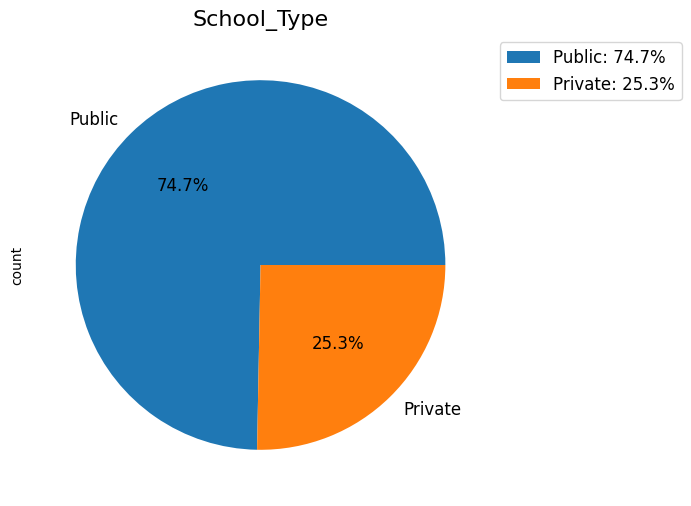


School_Location:
School_Location
Urban    0.5668
Rural    0.4332
Name: proportion, dtype: float64


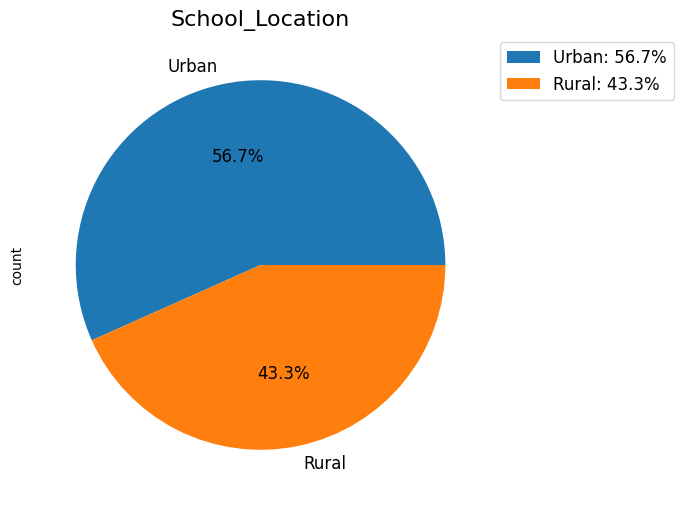


Extra_Tutorials:
Extra_Tutorials
Yes    0.5442
No     0.4558
Name: proportion, dtype: float64


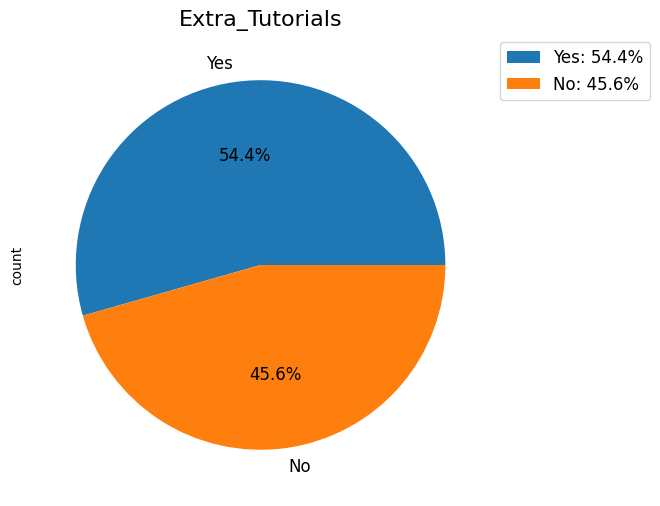


Access_To_Learning_Materials:
Access_To_Learning_Materials
Yes    0.6692
No     0.3308
Name: proportion, dtype: float64


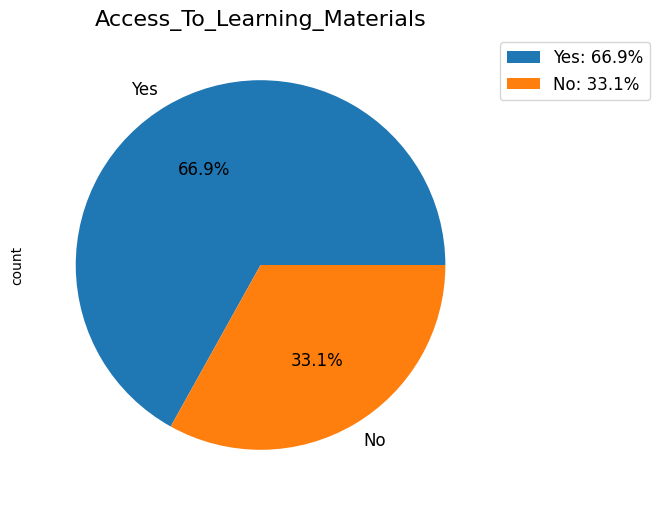


Parent_Involvement:
Parent_Involvement
Medium    0.4024
Low       0.3754
High      0.2222
Name: proportion, dtype: float64


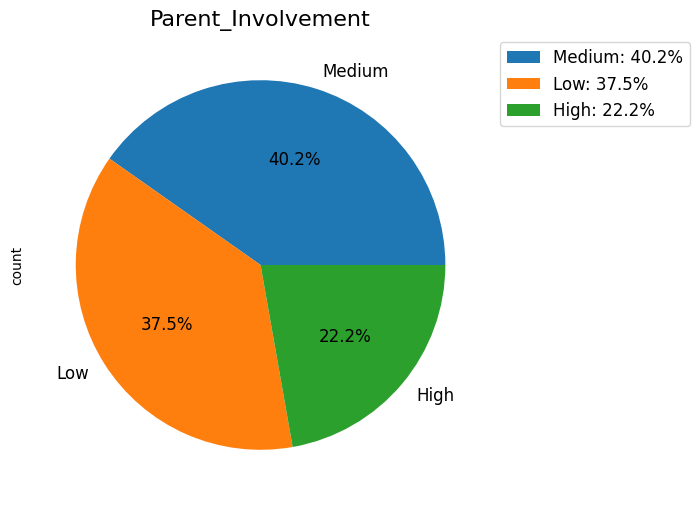


IT_Knowledge:
IT_Knowledge
Medium    0.3940
Low       0.3684
High      0.2376
Name: proportion, dtype: float64


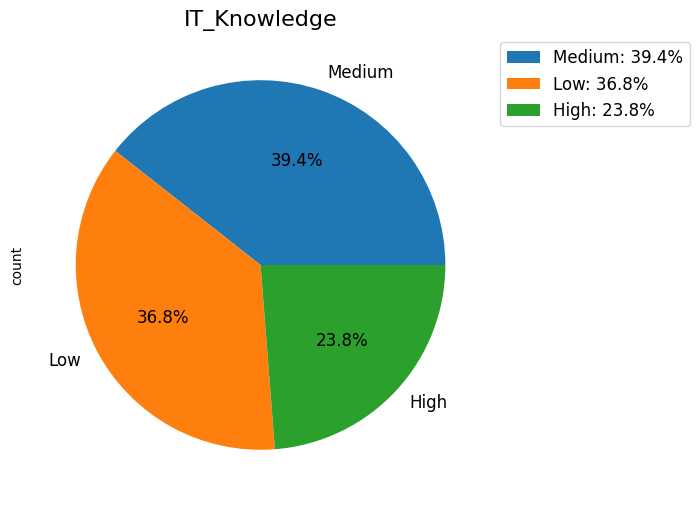


Gender:
Gender
Female    0.506
Male      0.494
Name: proportion, dtype: float64


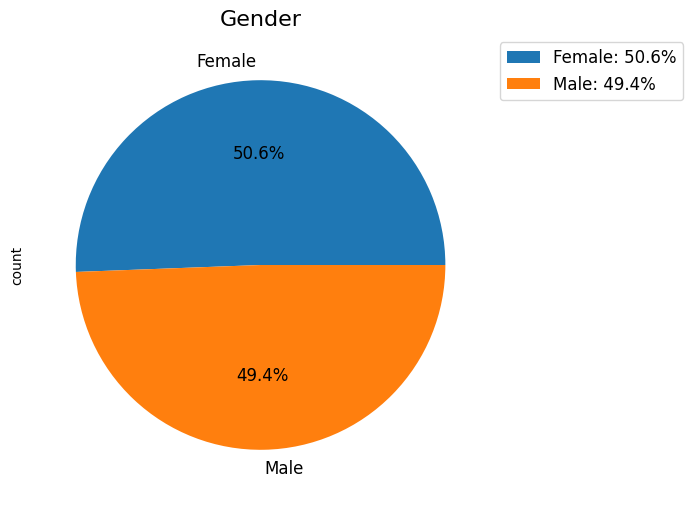


Socioeconomic_Status:
Socioeconomic_Status
Medium    0.3934
Low       0.3902
High      0.2164
Name: proportion, dtype: float64


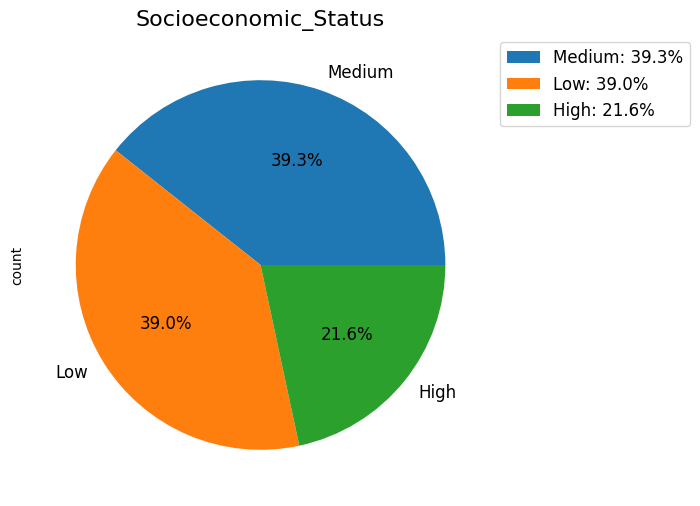


Parent_Education_Level:
Parent_Education_Level
Secondary    0.378681
Primary      0.324897
Tertiary     0.296422
Name: proportion, dtype: float64


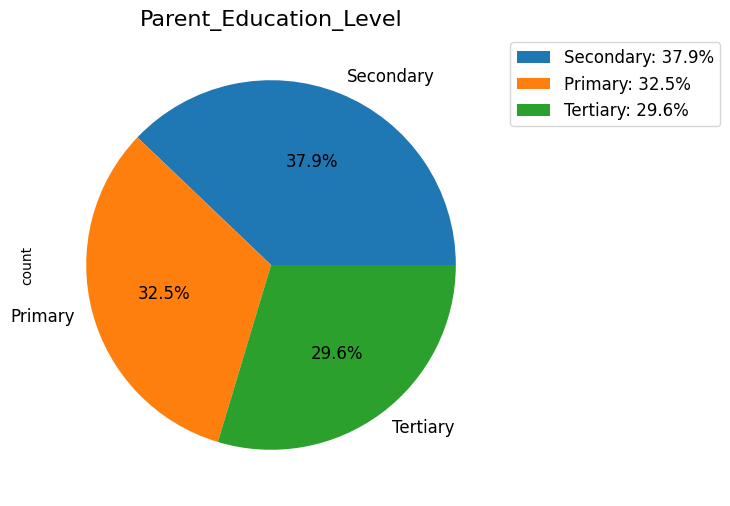

In [6]:
def basic_info(df):
    print("Основная информация:")
    print(df.info())
    print("\nПропущенные значения в числах:")
    print(df.isnull().sum())
    print('\nПропущенные значения в процентах')
    print(df.isnull().sum()/df.count()[0]*100)


def class_balance(df):
    print("Что у нас там по классам и нет ли там случаев 99% и более в одном классе:")
    for column in df.select_dtypes(include=['object', 'category']).columns:
        print(f"\n{column}:")
        print(df[column].value_counts(normalize=True))
        plt.figure(figsize=(12, 6))
        top = df[column].value_counts().head(5)
        top.plot.pie(autopct='%1.1f%%', fontsize=12)
        plt.title(column, fontsize=16)
        plt.legend([f'{i}: {j:.1f}%' for i, j in zip(top.index, top/top.sum()*100)], loc="upper left", bbox_to_anchor=(1, 0, 0.5, 1), fontsize=12)
        plt.show()

#Видим пропуски в Parent_Education_Level. 
basic_info(df)
#Когда было лень кроить ф-цию, но не лень менять тип данных чтобы посмотреть проценты
df['Assignments_Completed']=df['Assignments_Completed'].astype('string')
df['Teacher_Quality']=df['Teacher_Quality'].astype('string')
df['Age']=df['Age'].astype('string')
class_balance(df)
df['Assignments_Completed']=df['Assignments_Completed'].astype('int64')
df['Teacher_Quality']=df['Teacher_Quality'].astype('int64')
df['Age']=df['Age'].astype('int64')

In [7]:
#Переводим категориальные переменные в цифры
df['Parent_Involvement'] = df['Parent_Involvement'].replace({'Low': 0, 'Medium': 1, 'High': 2})
df['IT_Knowledge'] = df['IT_Knowledge'].replace({'Low': 0, 'Medium': 1, 'High': 2})
df['Socioeconomic_Status'] = df['Socioeconomic_Status'].replace({'Low': 0, 'Medium': 1, 'High': 2})


Что у нас там по классам и нет ли там случаев 99% и более в одном классе:

Parent_Education_Level:
Parent_Education_Level
Secondary    0.3112
Primary      0.2670
Tertiary     0.2436
no_data      0.1782
Name: proportion, dtype: float64


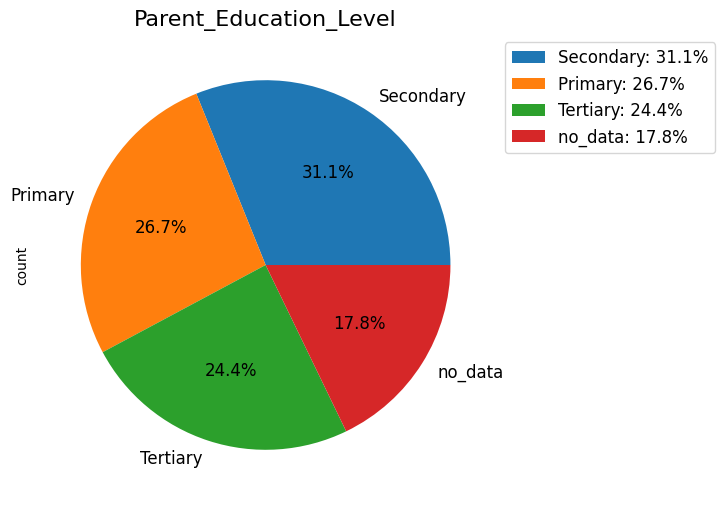

In [10]:
#заводим отдельный класс под потеряшек. 
#В принципе может быть рабочим "ленивым" вариантом. В конце концов, иногда отсутствие данных само по себе данные
#и то что именно по этим родителям нет данных об образовании может говорить как о не идеальном сборе данных так и о чём-то более интересном
#Склоняюсь именно к этому варианту (тем более ниже корреляционный анализ показывает интересные данные, подкрепляющие гипотезу о том что это не только не качественная работа по сбору данных)
df3=df.fillna({'Parent_Education_Level':'no_data'}).copy()
class_balance(df3[['Parent_Education_Level', 'Age']])

In [14]:
#В итоге берём один из вариантов заполнения. Решил взять вариант с отствие данных - тоже данные из-за выявленной корреляции отсутствия значения и более низкими иными признаками
#Смотрел через деми
df=df3

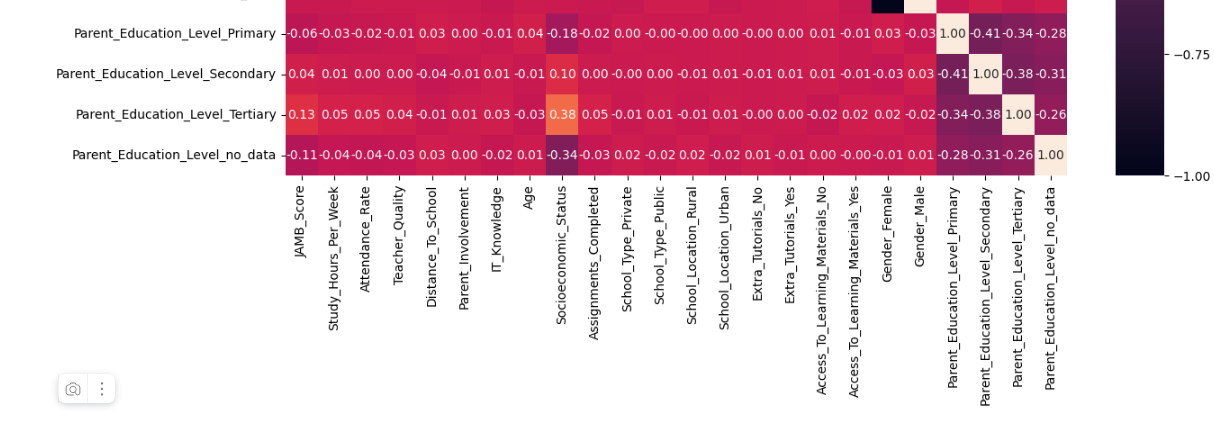

In [15]:
df['Parent_Education_Level'] = df['Parent_Education_Level'].replace({'no_data': 0, 'Primary': 1, 'Secondary': 2, 'Tertiary': 3})

In [ ]:
size=df.count()[0]
number_columns = df.select_dtypes(include=['number']).columns

In [24]:
from sklearn.preprocessing import MinMaxScaler 
#нормализуем
scaler = MinMaxScaler()
df[number_columns] = pd.DataFrame(scaler.fit_transform(df[number_columns]), columns=number_columns)
df.head()

,JAMB_Score,Study_Hours_Per_Week,Attendance_Rate,Teacher_Quality,Distance_To_School,School_Type,School_Location,Extra_Tutorials,Access_To_Learning_Materials,Parent_Involvement,IT_Knowledge,Age,Gender,Socioeconomic_Status,Parent_Education_Level,Assignments_Completed
0,0.344569,0.550,0.56,0.75,0.620,Public,Urban,Yes,Yes,1.0,0.5,0.285714,Male,0.0,1.0,0.25
1,0.400749,0.350,0.76,0.75,0.135,Public,Rural,No,Yes,1.0,1.0,0.000000,Male,1.0,0.0,0.00
2,0.307116,0.725,0.74,0.25,0.480,Public,Rural,Yes,Yes,1.0,0.5,0.714286,Female,1.0,1.0,0.25
3,0.411985,0.725,0.98,0.25,0.130,Public,Urban,No,Yes,0.5,1.0,1.000000,Female,0.5,1.0,0.00
4,0.370787,0.300,0.96,0.50,0.440,Public,Urban,No,Yes,0.5,0.5,1.000000,Female,0.5,1.0,0.00


In [26]:
#дэми переменные на не числовые столбцы
df=pd.get_dummies(df, drop_first=True)
basic_info(df)

Основная информация:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   JAMB_Score                        5000 non-null   float64
 1   Study_Hours_Per_Week              5000 non-null   float64
 2   Attendance_Rate                   5000 non-null   float64
 3   Teacher_Quality                   5000 non-null   float64
 4   Distance_To_School                5000 non-null   float64
 5   Parent_Involvement                5000 non-null   float64
 6   IT_Knowledge                      5000 non-null   float64
 7   Age                               5000 non-null   float64
 8   Socioeconomic_Status              5000 non-null   float64
 9   Parent_Education_Level            5000 non-null   float64
 10  Assignments_Completed             5000 non-null   float64
 11  School_Type_Public                5000 non-null 

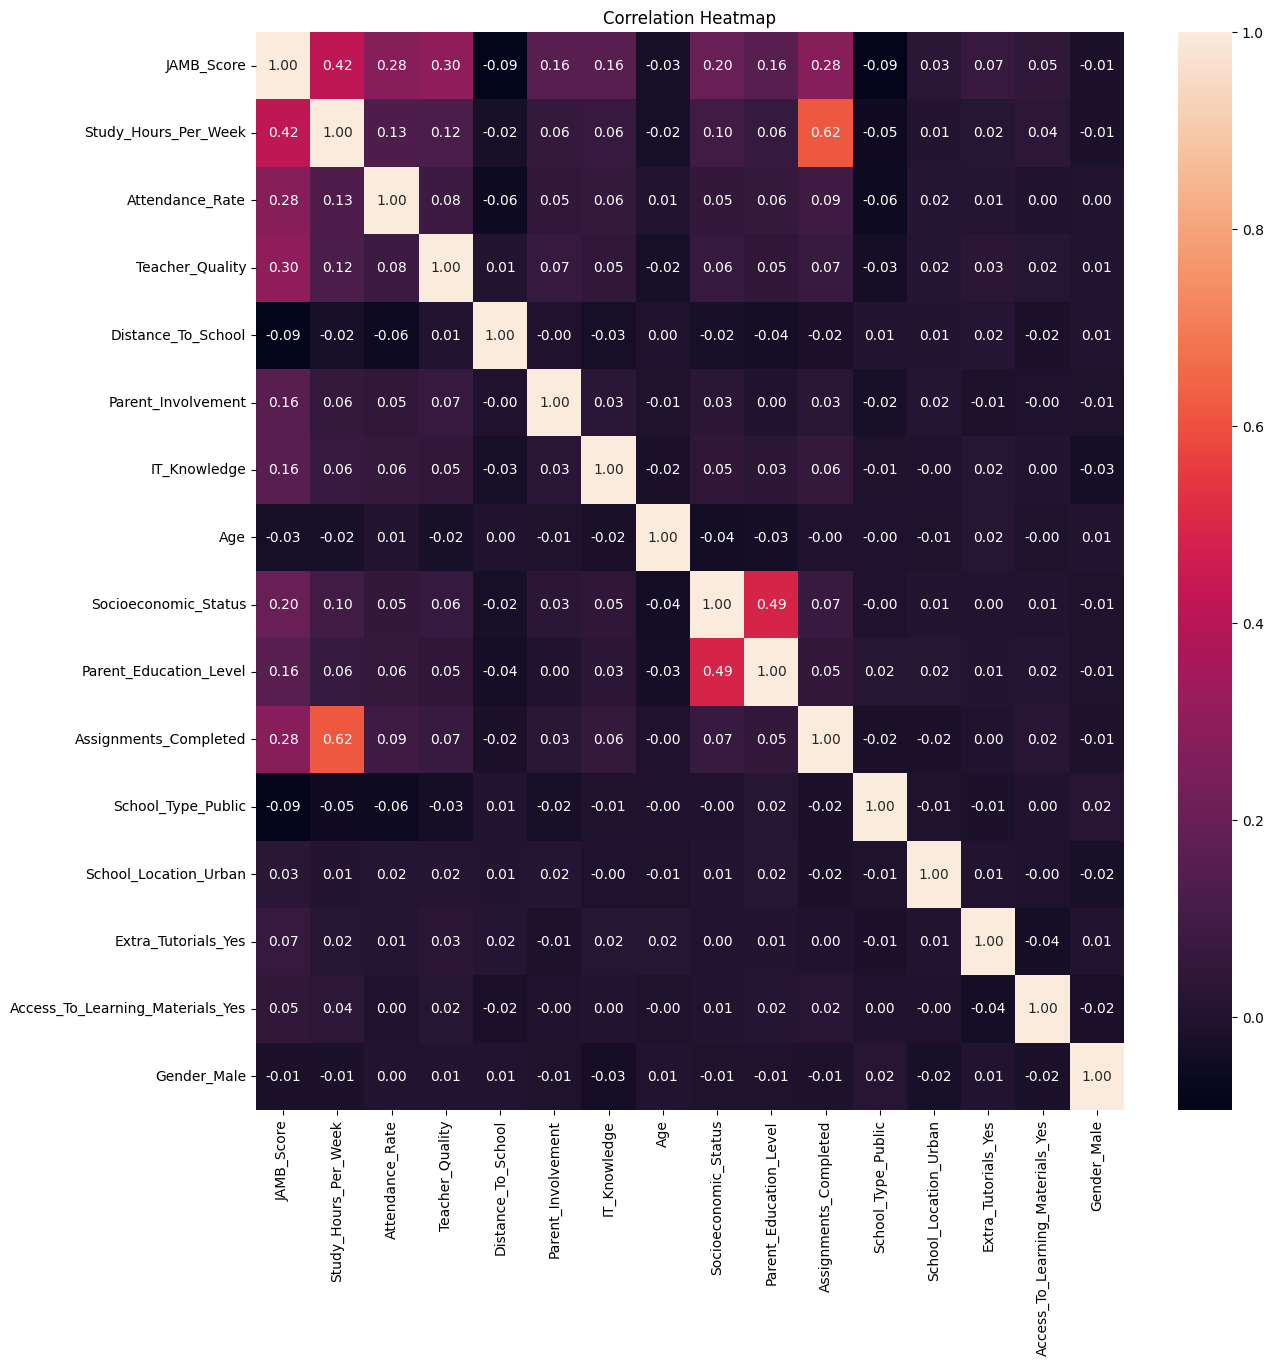

In [29]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.corr(), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


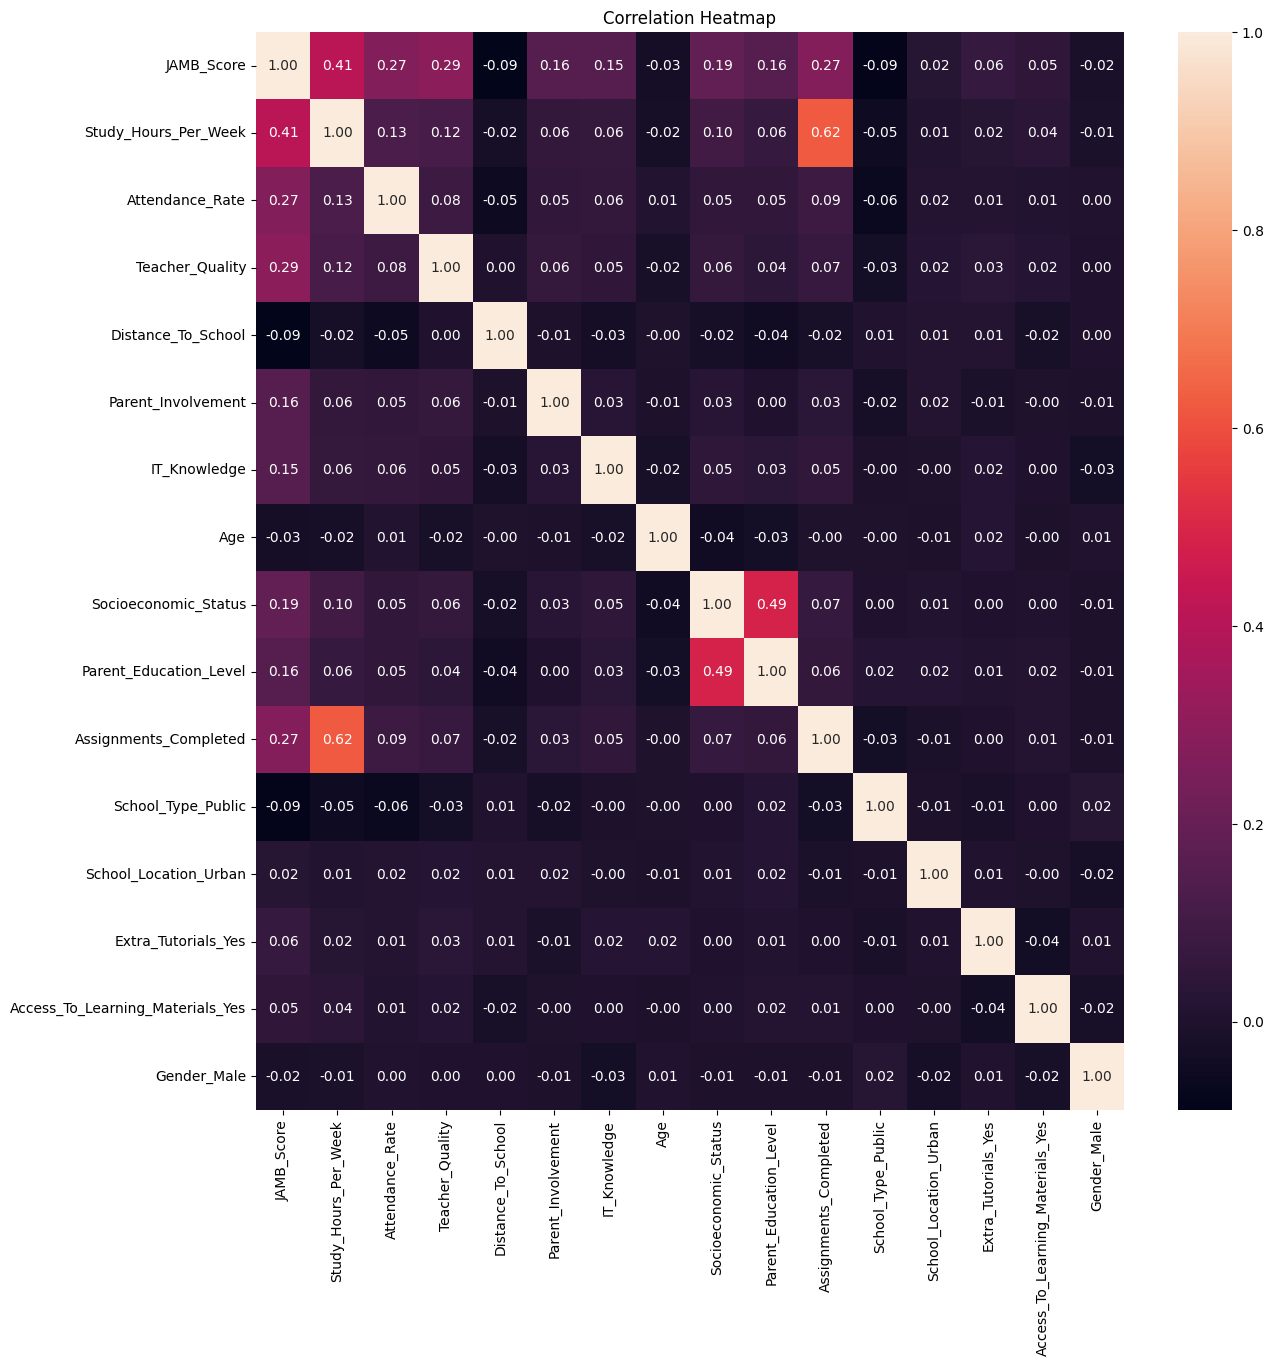

In [30]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.corr(method='spearman'), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


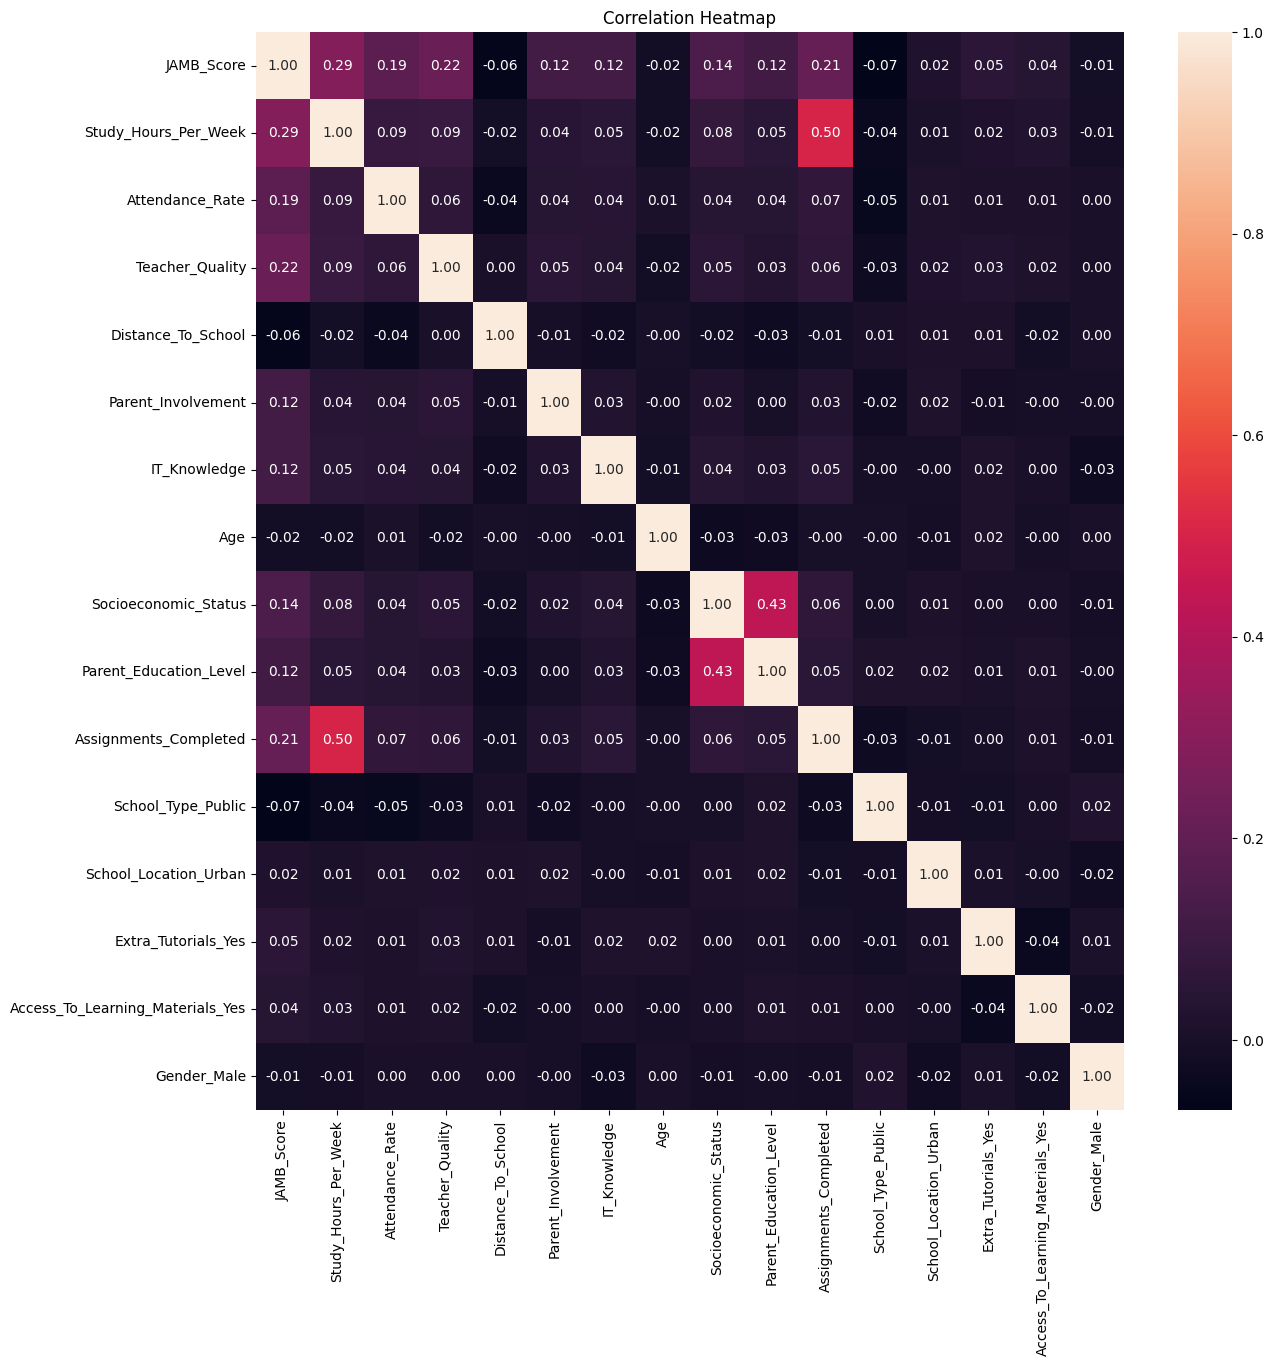

In [31]:
plt.figure(figsize=(14, 14))
sns.heatmap(df.corr(method='kendall'), annot=True, fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()
#Очень интересные корреляции в отсутствующих значениях и социальных данных. Study hours, Attendance Rate, Teacher Quality и Assignment Status тоже довольно хорошо коррелируют
#Ну и ожидаемо негативное влияние низких социальных параметров
#А вот пол, возраст и тип местности не настолько важны 


ждал более сильнофй корреляции мкежду часами и посещаемостью, если честно

Также уже видны параметры слабо коррелирующие с целевым

In [32]:
if activate_all: 
    sns.pairplot(df)
    plt.suptitle('Pair Plot', y=1.02)
    plt.show()

Гипотезы

Предпосылки: чем лучше экономическое положение семьи тем (предположительно) больше возможность выбора учебного заведения, а значит и подбора качественных учителей. Так же предположительно более квалифицированные учителя могут получить место в учебном заведении с более высоким престижем (короче, быстрый тест на экономическое неравенство)
Нулевая гипотеза: между социально-экономическим статусом и доступом к более профессиональным учителям нет явной связи.
Альтернативная: социально-экономический статус влияет на доступность более квалифицированных преподавателей.

Chi-square: 28.359807399322293 p-value: 0.00041045409047803336
Корреляция есть.


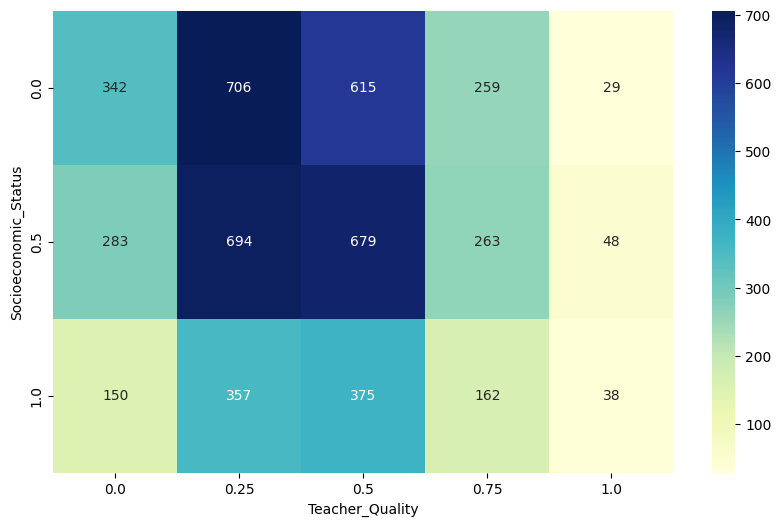

In [33]:

print('''Предпосылки: чем лучше экономическое положение семьи тем (предположительно) больше возможность выбора учебного заведения, а значит и подбора качественных учителей. Так же предположительно более квалифицированные учителя могут получить место в учебном заведении с более высоким престижем (короче, быстрый тест на экономическое неравенство)
Нулевая гипотеза: между социально-экономическим статусом и доступом к более профессиональным учителям нет явной связи.
Альтернативная: социально-экономический статус влияет на доступность более квалифицированных преподавателей.
''')


X = pd.crosstab(df.Socioeconomic_Status, df.Teacher_Quality)
chi2, p, dof, expected = chi2_contingency(X)
print('Chi-square:', chi2, 'p-value:', p)
if p<0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')


plt.figure(figsize=(10, 6))
sns.heatmap(X, annot=True, fmt='d', cmap='YlGnBu')
plt.show()

In [34]:
print('''
Хороших учителей всегда мало, в целом видно что просто из больших чисел большинство попадают на средне-низких, так-же есть определённая корреляция статусов, но она не определяющая. 
Так что можно предположить что социальное неравенство в сфере образования в Нигерии не настолько высоко, хотя и частично присутствует.
''')


Хороших учителей всегда мало, в целом видно что просто из больших чисел большинство попадают на средне-низких, так-же есть определённая корреляция статусов, но она не определяющая. 
Так что можно предположить что социальное неравенство в сфере образования в Нигерии не настолько высоко, хотя и частично присутствует.



Предпосылки: В городах  в целом больше возможностей, лучше инфраструктура и в целом обычно меньше препон к получению образование, что создаёт не равные условия
Нулевая гипотеза: Тип населённого пункта не влияет на результат
Альтернативная: Тип населённого пункта влияет на результат

T-statistic: 1.9800640637137368, p-value: 0.04775109059955254
Корреляция есть.


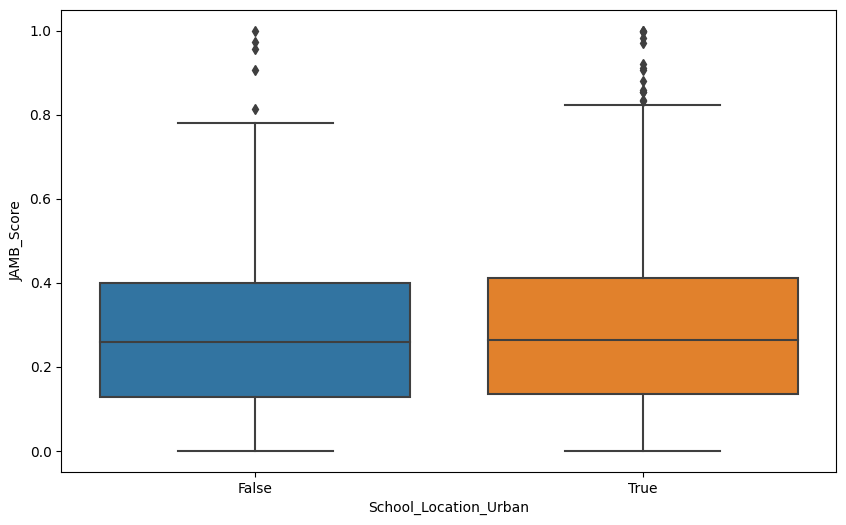

In [35]:

print('''Предпосылки: В городах  в целом больше возможностей, лучше инфраструктура и в целом обычно меньше препон к получению образование, что создаёт не равные условия
Нулевая гипотеза: Тип населённого пункта не влияет на результат
Альтернативная: Тип населённого пункта влияет на результат
''')
X = df[df['School_Location_Urban'] == 1]['JAMB_Score']
y = df[df['School_Location_Urban'] == 0]['JAMB_Score']
t_stat, p_value = ttest_ind(X, y)
print(f'T-statistic: {t_stat}, p-value: {p_value}')
if p<0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')

plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='School_Location_Urban', y='JAMB_Score')
plt.show()


In [36]:
print('''
Корреляция есть - ниже провел ряд тестов (не все вошли в итоговый отчет)
''')


Корреляция есть - ниже провел ряд тестов (не все вошли в итоговый отчет)



In [37]:

print('''Предпосылки: Доступ к учебным материала даёт больше преимуществ в городе из-за лучшей инфраструктуры и соответственно покрытия
Нулевая гипотеза: Тип локации не влияет на доступные материалы
Альтернативная: Тип локации влияет на качество и эффект учебных материалов
''')
model = ols('JAMB_Score ~ C(Access_To_Learning_Materials_Yes) * C(School_Location_Urban)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
if anova_table.loc['C(Access_To_Learning_Materials_Yes):C(School_Location_Urban)', 'PR(>F)'] < 0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')

Предпосылки: Доступ к учебным материала даёт больше преимуществ в городе из-за лучшей инфраструктуры и соответственно покрытия
Нулевая гипотеза: Тип локации не влияет на доступные материалы
Альтернативная: Тип локации влияет на качество и эффект учебных материалов

                                                        sum_sq      df  \
C(Access_To_Learning_Materials_Yes)                   0.355019     1.0   
C(School_Location_Urban)                              0.124808     1.0   
C(Access_To_Learning_Materials_Yes):C(School_Lo...    0.005907     1.0   
Residual                                            158.506401  4996.0   

                                                            F    PR(>F)  
C(Access_To_Learning_Materials_Yes)                 11.189932  0.000828  
C(School_Location_Urban)                             3.933843  0.047378  
C(Access_To_Learning_Materials_Yes):C(School_Lo...   0.186198  0.666119  
Residual                                                  NaN      

In [38]:

print('''Предпосылки: Хорошие специалисты чаще работают в городах, где лучше налажена жизнь
Нулевая гипотеза: Тип локации не влияет на уровень преподавателей
Альтернативная: Тип локации влияет на уровень преподавателей
''')
model = ols('JAMB_Score ~ C(Teacher_Quality) * C(School_Location_Urban)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
if anova_table.loc['C(Teacher_Quality):C(School_Location_Urban)', 'PR(>F)'] < 0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')

Предпосылки: Хорошие специалисты чаще работают в городах, где лучше налажена жизнь
Нулевая гипотеза: Тип локации не влияет на уровень преподавателей
Альтернативная: Тип локации влияет на уровень преподавателей

                                                 sum_sq      df           F  \
C(Teacher_Quality)                            14.320873     4.0  123.636911   
C(School_Location_Urban)                       0.089740     1.0    3.099030   
C(Teacher_Quality):C(School_Location_Urban)    0.048436     4.0    0.418167   
Residual                                     144.498019  4990.0         NaN   

                                                    PR(>F)  
C(Teacher_Quality)                           9.090671e-101  
C(School_Location_Urban)                      7.840022e-02  
C(Teacher_Quality):C(School_Location_Urban)   7.956663e-01  
Residual                                               NaN  
Нулевая гипотеза - связь не подтверждена


In [39]:

print('''Предпосылки:В городе лучше связь, больше шансов что протянули волокно и т.д.
Нулевая гипотеза: Тип локации не влияет на компьютерные знания
Альтернативная: Тип локации влияет на качество и эффект учебных материалов
''')
model = ols('JAMB_Score ~ C(IT_Knowledge) * C(School_Location_Urban)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
if anova_table.loc['C(IT_Knowledge):C(School_Location_Urban)', 'PR(>F)'] < 0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')

Предпосылки:В городе лучше связь, больше шансов что протянули волокно и т.д.
Нулевая гипотеза: Тип локации не влияет на компьютерные знания
Альтернативная: Тип локации влияет на качество и эффект учебных материалов

                                              sum_sq      df          F  \
C(IT_Knowledge)                             4.312995     2.0  69.726590   
C(School_Location_Urban)                    0.126470     1.0   4.089178   
C(IT_Knowledge):C(School_Location_Urban)    0.100365     2.0   1.622565   
Residual                                  154.453968  4994.0        NaN   

                                                PR(>F)  
C(IT_Knowledge)                           1.358985e-30  
C(School_Location_Urban)                  4.321183e-02  
C(IT_Knowledge):C(School_Location_Urban)  1.974959e-01  
Residual                                           NaN  
Нулевая гипотеза - связь не подтверждена


In [40]:

print('''Предпосылки: Доступ к учебным материала даёт больше преимуществ в городе из-за лучшей инфраструктуры и соответственно покрытия
Нулевая гипотеза: Тип локации не влияет на доступные материалы
Альтернативная: Тип локации влияет на качество и эффект учебных материалов
''')
model = ols('JAMB_Score ~ C(Extra_Tutorials_Yes) * C(School_Location_Urban)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
if anova_table.loc['C(Extra_Tutorials_Yes):C(School_Location_Urban)', 'PR(>F)'] < 0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')

Предпосылки: Доступ к учебным материала даёт больше преимуществ в городе из-за лучшей инфраструктуры и соответственно покрытия
Нулевая гипотеза: Тип локации не влияет на доступные материалы
Альтернативная: Тип локации влияет на качество и эффект учебных материалов

                                                     sum_sq      df  \
C(Extra_Tutorials_Yes)                             0.719227     1.0   
C(School_Location_Urban)                           0.120892     1.0   
C(Extra_Tutorials_Yes):C(School_Location_Urban)    0.000215     1.0   
Residual                                         158.147886  4996.0   

                                                         F    PR(>F)  
C(Extra_Tutorials_Yes)                           22.720869  0.000002  
C(School_Location_Urban)                          3.819048  0.050729  
C(Extra_Tutorials_Yes):C(School_Location_Urban)   0.006793  0.934316  
Residual                                               NaN       NaN  
Нулевая гипотеза - связ

In [41]:

print('''Предпосылки: В сельской местности сильнее традиционные взгляды препятствующие получению образования девушкам
Нулевая гипотеза: Тип локации не влияет на доступные материалы
Альтернативная: Тип локации влияет на качество и эффект учебных материалов
''')
model = ols('JAMB_Score ~ C(Gender_Male) * C(School_Location_Urban)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)
if anova_table.loc['C(Gender_Male):C(School_Location_Urban)', 'PR(>F)'] < 0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')

Предпосылки: В сельской местности сильнее традиционные взгляды препятствующие получению образования девушкам
Нулевая гипотеза: Тип локации не влияет на доступные материалы
Альтернативная: Тип локации влияет на качество и эффект учебных материалов

                                             sum_sq      df         F  \
C(Gender_Male)                             0.031203     1.0  0.981503   
C(School_Location_Urban)                   0.121757     1.0  3.829903   
C(Gender_Male):C(School_Location_Urban)    0.007735     1.0  0.243320   
Residual                                 158.828390  4996.0       NaN   

                                           PR(>F)  
C(Gender_Male)                           0.321876  
C(School_Location_Urban)                 0.050401  
C(Gender_Male):C(School_Location_Urban)  0.621840  
Residual                                      NaN  
Нулевая гипотеза - связь не подтверждена


Предпосылки: Логичное предположение что количество учебных часов переходит в качество
Нулевая гипотеза: Связь затрачиваемого на учёбу времени с итоговыми баллами отсутствует
Альтернативная: Чем больше часов тратишь на учёбу тем (обычно) лучше

Pearson correlation: 0.4200612209671165, P-value: 5.447012243615685e-213
Корреляция есть.


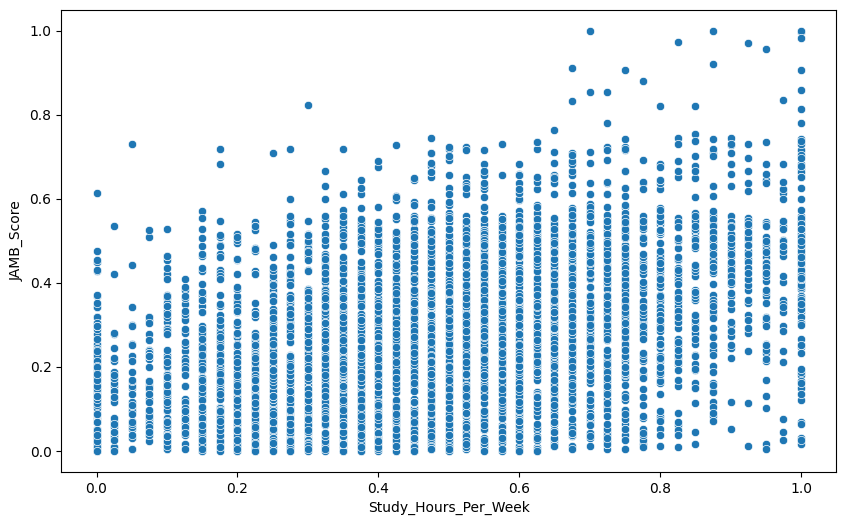

In [42]:

print('''Предпосылки: Логичное предположение что количество учебных часов переходит в качество
Нулевая гипотеза: Связь затрачиваемого на учёбу времени с итоговыми баллами отсутствует
Альтернативная: Чем больше часов тратишь на учёбу тем (обычно) лучше
''')
corr, p = pearsonr(df['Study_Hours_Per_Week'], df['JAMB_Score'])
print(f'Pearson correlation: {corr}, P-value: {p}')
if p<0.05:
    print('Корреляция есть.')
else:
    print('Нулевая гипотеза - связь не подтверждена')
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df['Study_Hours_Per_Week'], y=df['JAMB_Score'])
plt.xlabel('Study_Hours_Per_Week')
plt.ylabel('JAMB_Score')
plt.show()


In [43]:
print('''
Терпение и труд - один из основных секретов учёбы
''')


Терпение и труд - один из основных секретов учёбы

